In [1]:
libs <- c(
    'dplyr',
    'tidyr',
    'stringr',
    'ggplot2'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

# source("http://bioconductor.org/biocLite.R")
# biocLite("BSgenome.Hsapiens.UCSC.hg38")
library(BSgenome.Hsapiens.UCSC.hg38)
hg38 = BSgenome.Hsapiens.UCSC.hg38


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: BSgenome
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, 

In [2]:
source("utility_functions.R")
source("stat_functions.R")
source("plot_functions.R")
source("~/git-repos/BDDS/trenadb/src/utils.R")

Loading required package: DBI


[1] --- test.locStringToBedTable
[1] --- test.getFimoHits
[1] --- test.getHits
[1] --- test.createHintTable
[1] found 194 hint hits in 101 bases
[1] found 16 hint hits in 101 bases
[1] found 14 hint hits in 101 bases
[1] found 10 hint hits in 19 bases
[1] found 995 hint hits in 20019 bases
[1] --- test.createHintTable_ignoreStrand
[1] found 44 hint hits in 12 bases
[1] found 44 hint hits in 12 bases
[1] eliminating 11 double-stranded hits
[1] --- test.createWellingtonTable
[1] found 126 wellington hits in 19 bases
[1] found 378 wellington hits in 20019 bases
[1] found 68 wellington hits in 12 bases
[1] found 4 wellington hits in 12 bases
[1] found 126 wellington hits in 19 bases
[1] found 64 wellington hits in 19 bases
[1] found 24 wellington hits in 19 bases
[1] --- test.createWellingtonTable_ignoreStrand, deferred
[1] found 26 wellington hits in 10 bases
[1] found 26 wellington hits in 10 bases
[1] eliminating 13 double-stranded hits
[1] --- test.createPiqTable
[1] found 342 piq hits

## cleaning and splitting functions

In [3]:
# function to split data into independent classifier work set and 
# ensemble classifier work set
split.halves.physically <- function(df, p=0.5, buffer=100) {
    # p is the portion of the data used for independent classifier work
    # the rest is set aside for ensemble classifier work
    
    require("tibble")
    df <- as_data_frame(df)

    df <- ft.clean.corymotifs.tfclasses
    my.center <- (min(df$start) + max(df$end))/2

    first.half.bool.inds <- df$end + buffer/2 < my.center
    second.half.bool.inds <- df$start - buffer/2 > my.center

    first.half.df <- df[first.half.bool.inds,]
    second.half.df <- df[second.half.bool.inds,]
    
    out.list <- list()
    out.list$first.half <- first.half.df
    out.list$second.half <- second.half.df

    return(out.list)
}

# function to split data in to training, testing, and validation sets
split.test.train.valid.physically <- function(df, p.train=0.7, p.test=0.2, p.valid=0.1,
                                              buffer=100, reverse.order=FALSE) {
    
    # physically split: train | test | valid
    
    require("tibble")
    stopifnot(p.train + p.test + p.valid <= 1)
    
    df <- as_data_frame(df[with(df, order(start, decreasing=reverse.order)), ])
    
    tt.split.ind <- round(p.train*nrow(df))
    tv.split.ind <- round((p.train+p.test)*nrow(df))
    
    train.inds.bool <- 1:nrow(df) < tt.split.ind
    valid.inds.bool <- 1:nrow(df) > tv.split.ind
    test.inds.bool <- !(train.inds.bool | valid.inds.bool)
    
    train.df <- df[train.inds.bool,]
    test.df <- df[test.inds.bool,]
    valid.df <- df[valid.inds.bool,]
    
    out.list <- list()
    out.list$train <- train.df
    out.list$test <- test.df
    out.list$valid <- valid.df
    
    return(out.list)
}


# # function to split data into independent classifier work set and 
# # ensemble classifier work set
# split.ic.ec <- function(df, p=0.5) {
#     # p is the portion of the data used for independent classifier work
#     # the rest is set aside for ensemble classifier work
    
#     require("tibble")
    
#     df <- as_data_frame(df)
#     N.all <- dim(df)[1]
    
#     all.inds <- c(1:N.all)
#     ic.inds <- sample(N.all, round(p*N.all), replace=FALSE)
    
#     ic.inds.bool <- all.inds %in% ic.inds
#     ec.inds.bool <- !ic.inds.bool
    
#     ic.df <- df[ic.inds.bool,]
#     ec.df <- df[ec.inds.bool,]
    
#     out.list <- list()
#     out.list$ic <- ic.df
#     out.list$ec <- ec.df

#     return(out.list)
# }


# # function to split data in to training, testing, and validation sets
# split.test.train.valid <- function(df, p.tt=0.75, p.valid=0.25) {
#     # p.valid is the portion of the data set aside for validation
#     # p.tt is the fraction of the remaining data used for training

#     require("tibble")
    
#     df <- as_data_frame(df)
#     N.all <- nrow(df)

#     all.inds <- c(1:N.all)
#     valid.inds <- sample(N.all, round(p.valid*N.all), replace=FALSE)

#     valid.inds.bool <- all.inds %in% valid.inds
#     tt.inds.bool <- !valid.inds.bool
    
#     valid.df <- df[valid.inds.bool,]
#     tt.df <- df[tt.inds.bool,]

#     N.tt <- nrow(tt.df)
#     tt.inds <- c(1:N.tt)
#     train.inds <- sample(N.tt, round(p.tt*N.tt), replace=FALSE)

#     train.inds.bool <- tt.inds %in% train.inds
#     test.inds.bool <- !train.inds.bool

#     train.df <- tt.df[train.inds.bool,]
#     test.df <- tt.df[test.inds.bool,]

#     out.list <- list()
#     out.list$train <- train.df
#     out.list$test <- test.df
#     out.list$valid <- valid.df
    
#     return(out.list)
# }

## Load Data

In [4]:
# df loads as "tb;" variable
load("~/git-repos/BDDS/trenadb/featureTable/lymphoblast/featureTableLymphoblast-chr19-entire.RData")

# remove any duplicate rows
tbl.nodupes <- tbl[!duplicated(tbl),]

# fix spurious zeros in piq score 2 
tmp <- tbl.nodupes$score2.p
tmp[tmp == 0] <- -999
tbl.nodupes$score2.p <- tmp

In [5]:
# cory's motif to tf-class mapping
tf.fams.file <- "/local/Cory/for_Paul/motif_class_fam"
tf.fams.table <- read.delim(tf.fams.file, stringsAsFactors=FALSE)

In [6]:
# check overlap of motif names from cory and paul

motif.names.from.cory <- str_replace_all(string=tf.fams.table$ID, pattern="[[:space:]]", repl="")
motif.names.from.paul <- unique(tbl.nodupes$motif)

# motifs not occurring from sample data
from.cory.not.in.paul <- motif.names.from.cory[!(motif.names.from.cory %in% motif.names.from.paul)]

# motifs not mapped in cory's table
from.paul.not.in.cory <- motif.names.from.paul[!(motif.names.from.paul %in% motif.names.from.cory)]

# number of motifs that i'll use
from.paul.in.cory <- sort(motif.names.from.paul[(motif.names.from.paul %in% motif.names.from.cory)])
length(from.paul.in.cory)

[1] 510

In [7]:
# filter out the motifs in pauls' table that cory doesn' have tf classes for
ft.clean.corymotifs <- tbl.nodupes %>% filter(motif %in% from.paul.in.cory)

In [8]:
# find unique tf class names from cory's list

class.names.nospaces <- str_replace_all(string=tf.fams.table$class, pattern="[[:space:]]", repl="")
unique.class.names.nospaces <- unique(class.names.nospaces)
double.entry.classes <- grep('::', unique.class.names.nospaces, value=TRUE)
dedoubled.classes <- unique(unlist(strsplit(double.entry.classes,'::')))

class.names.nospaces.minus.doubles <- unique.class.names.nospaces[!(unique.class.names.nospaces %in% double.entry.classes)]
class.names.final <- sort(unique(c(class.names.nospaces.minus.doubles,dedoubled.classes)))
length(class.names.final)

[1] 30

In [9]:
# cory's map: arrange so grepping on class column will yeild matches from paul's names

tf.fams.table.renamed <- tf.fams.table
tf.fams.table.renamed$ID <- str_replace_all(string=tf.fams.table.renamed$ID, pattern="[[:space:]]", repl="")
tf.fams.table.renamed <- tf.fams.table.renamed %>% filter(ID %in% from.paul.in.cory)
rownames(tf.fams.table.renamed) <- tf.fams.table.renamed$ID
tf.class.foreach.motif <- tf.fams.table.renamed[,-c(1)]

tf.class.foreach.motif$class <- str_replace_all(string=tf.class.foreach.motif$class, pattern="[[:space:]]", repl="")

In [10]:
# make sparse class / tf feature matrix map
# all zeros to start, fill in ones below
tf.motif.class.matrix <- matrix(0L, nrow = length(from.paul.in.cory), ncol = length(class.names.final))
rownames(tf.motif.class.matrix) <- from.paul.in.cory
colnames(tf.motif.class.matrix) <- class.names.final

# loop through tfs and classes to fill in ones where there is a match

for (tf.name in rownames(tf.motif.class.matrix)) {
    for (class.name in colnames(tf.motif.class.matrix)) {
        class.to.check <- tf.class.foreach.motif[tf.name,'class']
        classes.match <- any(grep(class.name, class.to.check, value=FALSE, fixed=TRUE))
        if (classes.match == 1) {
            tf.motif.class.matrix[tf.name,class.name] <- 1
        }
    }
    
}

In [11]:
# number of motifs with extra entries is small:
dim(tf.motif.class.matrix)
sum(tf.motif.class.matrix)

# check to see if any motifs didn't match
rownames(tf.motif.class.matrix)[rowSums(tf.motif.class.matrix) == 0]

[1] 510  30

[1] 513

character(0)

In [12]:
# merging is a way saner way to... merge dataframes, who knew?
tf.motif.class.df <- as.data.frame(tf.motif.class.matrix)
tf.motif.class.df$motif <- rownames(tf.motif.class.df)
dim(tf.motif.class.df)

ft.clean.corymotifs.tfclasses <- merge(ft.clean.corymotifs, tf.motif.class.df, by="motif", all.x=TRUE)
dim(ft.clean.corymotifs.tfclasses)

[1] 510  31

[1] 1136194      51

In [13]:
# check to see if any loc/motifs didn't get a class
rownames(ft.clean.corymotifs.tfclasses)[rowSums(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)]) == 0]

character(0)

In [14]:
# most entries just have one class
dim(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])[1]
sum(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])

[1] 1136194

[1] 1139416

## Split data into different sets

In [15]:
# split into test, train, validation dfs for both
# independent classifier (ic) and ensemble classifier(ec) work
# ic and ec are on different halfs of the chromasome, so no potential for overlap

halves.list <- split.halves.physically(ft.clean.corymotifs.tfclasses)

first.half.df <- halves.list$first.half
second.half.df <- halves.list$second.half

Loading required package: tibble


In [16]:
first.half.train.test.valid.list <- split.test.train.valid.physically(first.half.df, reverse.order = TRUE)
second.half.train.test.valid.list <- split.test.train.valid.physically(second.half.df, reverse.order = FALSE)

first.half.train.df <- first.half.train.test.valid.list$train
first.half.test.df <- first.half.train.test.valid.list$test
first.half.valid.df <- first.half.train.test.valid.list$valid

second.half.train.df <- second.half.train.test.valid.list$train
second.half.test.df <- second.half.train.test.valid.list$test
second.half.valid.df <- second.half.train.test.valid.list$valid

In [17]:
nrow(first.half.df) + nrow(second.half.df)

nrow(first.half.train.df) + nrow(first.half.test.df) + nrow(first.half.valid.df)
nrow(second.half.train.df) + nrow(second.half.test.df) + nrow(second.half.valid.df)

[1] 1136194

[1] 585747

[1] 550447

In [22]:
# can't just split on loc, need to sort on loc and then split by quantile...
# no need for new computations, can just sort on start colunn then split

tmp.first.half.train.df <- first.half.train.df
tmp.first.half.test.df <- first.half.test.df
tmp.first.half.valid.df <- first.half.valid.df
tmp.second.half.train.df <- second.half.train.df
tmp.second.half.test.df <- second.half.test.df
tmp.second.half.valid.df <- second.half.valid.df

tmp.first.half.train.df$type <- "f.train"
tmp.first.half.test.df$type <- "f.test"
tmp.first.half.valid.df$type <- "f.valid"
tmp.second.half.train.df$type <- "s.train"
tmp.second.half.test.df$type <- "s.test"
tmp.second.half.valid.df$type <- "s.valid"

tot.df <- rbind(
    tmp.first.half.train.df,
    tmp.first.half.test.df,
    tmp.first.half.valid.df,
    tmp.second.half.train.df,
    tmp.second.half.test.df,
    tmp.second.half.valid.df)

# mean(first.half.train.df$csscore > 0)
# mean(first.half.test.df$csscore > 0)
# mean(first.half.valid.df$csscore > 0)
# mean(second.half.train.df$csscore > 0)
# mean(second.half.test.df$csscore > 0)
# mean(second.half.valid.df$csscore > 0)

In [24]:
p <- ggplot(tot.df) +
    geom_histogram(aes(x=start, fill=type), bins=1000) +
    theme_minimal()

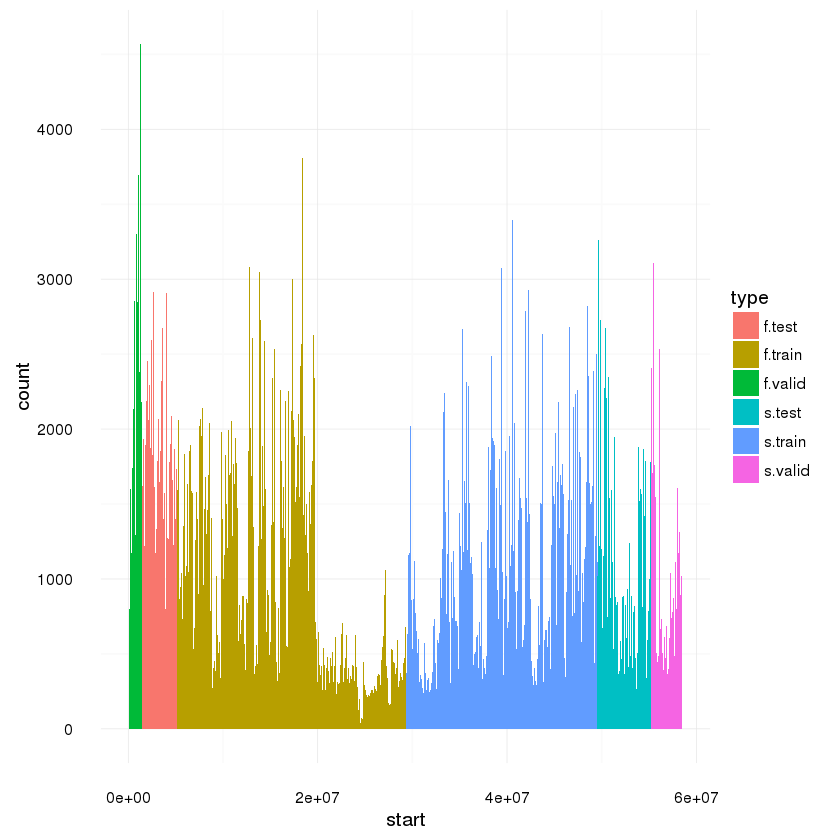

In [25]:
p

In [26]:
save(first.half.train.df,
     first.half.test.df,
     first.half.valid.df,
     second.half.train.df,
     second.half.test.df,
     second.half.valid.df,
     file="train_test_valid_data_sets.Rdata")